In [120]:
import polars as pl
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta
from tqdm import tqdm
import itertools
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Iniciar Faker
fake = Faker('es_CO')
np.random.seed(42)
random.seed(42)

# --- Parámetros ---
n_ventas = 200000
n_clientes = 1500
n_canales = 5
n_promociones = 50
n_regiones = 5

start_date_data = datetime(2022, 1, 1)
end_date_data = datetime(2025, 9, 30)

# Parámetros de Elasticidad (suavizados)
elasticidades_por_categoria = {
    'Agua': {'min': -0.2, 'max': -0.3, 'elastico': False},
    'Gaseosa': {'min': -0.3, 'max': -0.4, 'elastico': True},
    'Bebida de Té': {'min': -0.8, 'max': -1.2, 'elastico': True},
    'Bebida Energética': {'min': -1.0, 'max': -1.8, 'elastico': True}
}
prob_elasticidad_positiva = 0.03
rango_elasticidad_positiva = {'min': 0.03, 'max': 0.15}

# --- Parámetros de Control de Fluctuación ---
MAX_PERCENT_CHANGE_PER_MONTH_PRODUCT_AGGREGATE = 0.05  # Menor para evitar saltos abruptos
MIN_QUANTITY_PER_SALE = 24
MAX_QUANTITY_PER_SALE = 120
DAILY_QUANTITY_FLUCTUATION_FACTOR = 0.05  # Menor para suavizar fluctuaciones diarias

# --- Ajuste de Temporalidad (estacionalidad equilibrada)
seasonal_multipliers = {
    1: random.uniform(0.95, 1.05),
    2: random.uniform(1.0, 1.05),
    3: random.uniform(0.95, 1.05),
    4: random.uniform(1.0, 1.05),
    5: random.uniform(0.95, 1.05),
    6: random.uniform(1.10, 1.15),
    7: random.uniform(1.15, 1.35),
    8: random.uniform(1.15, 1.35),
    9: random.uniform(0.95, 1.05),
    10: random.uniform(1.0, 1.05),
    11: random.uniform(1.0, 1.15),
    12: random.uniform(1.15, 1.45)
}

# --- Parámetros de Impacto en las Promociones ---
PROMOTION_ELASTICITY_MULTIPLIER = 1.2
MIN_PROMOTION_BOOST = 1.1
MAX_PROMOTION_BOOST = 1.5

# --- 1. Tabla Región ---
ciudades_colombia = [
    {"nombre_region": "Cundinamarca", "ciudad": "Bogotá", "latitud": 4.7110, "longitud": -74.0721},
    {"nombre_region": "Antioquia", "ciudad": "Medellín", "latitud": 6.2442, "longitud": -75.5812},
    {"nombre_region": "Valle del Cauca", "ciudad": "Cali", "latitud": 3.4516, "longitud": -76.5320},
    {"nombre_region": "Atlántico", "ciudad": "Barranquilla", "latitud": 10.9685, "longitud": -74.7813},
    {"nombre_region": "Bolívar", "ciudad": "Cartagena", "latitud": 10.3910, "longitud": -75.4794}
]

regiones_data = []
for i in tqdm(range(n_regiones), desc="Generando regiones", mininterval=1):
    region_info = ciudades_colombia[i]
    regiones_data.append({
        'region_id': i + 1,
        'nombre_region': region_info['nombre_region'],
        'ciudad': region_info['ciudad'],
        'latitud': region_info['latitud'],
        'longitud': region_info['longitud']
    })
df_regiones = pl.DataFrame(regiones_data)

pesos_regiones = {
    "Bogotá": 0.20, "Medellín": 0.25, "Cali": 0.15, "Barranquilla": 0.15, "Cartagena": 0.10
}
prob_regiones_para_seleccion = np.array([pesos_regiones.get(row['ciudad'], 0.01) for row in df_regiones.iter_rows(named=True)])
prob_regiones_para_seleccion /= prob_regiones_para_seleccion.sum()
regiones_para_seleccion = df_regiones['region_id'].to_list()

# --- 2. Tabla Clientes ---
ciudades_regiones = df_regiones['ciudad'].to_list()
fecha_actual = end_date_data
fecha_365_dias_atras = fecha_actual - timedelta(days=365)

porcentaje_inactivos = random.uniform(0.05, 0.15)
n_clientes_inactivos = int(n_clientes * porcentaje_inactivos)
n_clientes_activos = n_clientes - n_clientes_inactivos

ciudad_to_region_id = {row['ciudad']: row['region_id'] for row in df_regiones.iter_rows(named=True)}

clientes = []
for i in tqdm(range(1, n_clientes + 1), desc="Generando clientes", mininterval=1):
    es_inactivo = i <= n_clientes_inactivos
    
    if es_inactivo:
        ultima_compra = fake.date_between(start_date=fecha_actual - timedelta(days=730), end_date=fecha_365_dias_atras)
        base_frecuencia = np.random.randint(1, 5)
    else:
        ultima_compra = fake.date_between(start_date=fecha_365_dias_atras, end_date=fecha_actual)
        base_frecuencia = np.random.randint(5, 15)
        base_frecuencia = min(base_frecuencia, 30)

    ciudad = np.random.choice(ciudades_regiones, p=prob_regiones_para_seleccion)
    region_id = ciudad_to_region_id[ciudad]

    year = ultima_compra.year
    if year >= 2024:
        canal_preferencia = np.random.choice(['E-commerce', 'Hipermercado', 'Supermercado', 'Tienda de Conveniencia', 'Farmacia'],
                                           p=[0.20, 0.30, 0.25, 0.15, 0.10])
    else:
        canal_preferencia = np.random.choice(['E-commerce', 'Hipermercado', 'Supermercado', 'Tienda de Conveniencia', 'Farmacia'],
                                           p=[0.05, 0.35, 0.25, 0.2, 0.15])

    clientes.append({
        'cliente_id': i,
        'nombre': fake.name(),
        'edad': np.random.randint(18, 80),
        'genero': np.random.choice(['M', 'F']),
        'ciudad': ciudad,
        'region_id': region_id,
        'frecuencia_compra': base_frecuencia,
        'ultima_compra': ultima_compra,
        'canal_preferencia': canal_preferencia
    })
df_clientes = pl.DataFrame(clientes)

# --- 3. Tabla de Promociones ---
promociones_data = []
for i in tqdm(range(1, n_promociones + 1), desc="Generando promociones", mininterval=1):
    fecha_inicio = fake.date_between(start_date=start_date_data - timedelta(days=180), end_date=end_date_data - timedelta(days=90))
    fecha_fin = fecha_inicio + timedelta(days=random.randint(30, 180))
    if fecha_fin > end_date_data.date():
        fecha_fin = end_date_data.date()
    promociones_data.append({
        'promocion_id': i,
        'nombre_promocion': f"Promo {i}",
        'descuento_porcentaje': np.random.randint(5, 30),
        'fecha_inicio': fecha_inicio,
        'fecha_fin': fecha_fin
    })
df_promociones = pl.DataFrame(promociones_data)

avg_promotion_discount = df_promociones['descuento_porcentaje'].mean() / 100
clientes_updated = []
for cliente in tqdm(df_clientes.iter_rows(named=True), desc="Actualizando clientes con promociones", mininterval=1):
    base_frecuencia = cliente['frecuencia_compra']
    if cliente['cliente_id'] > n_clientes_inactivos:
        promotion_sensitivity = 1 + (avg_promotion_discount * random.uniform(0.5, 1.5))
        base_frecuencia = int(base_frecuencia * promotion_sensitivity)
        base_frecuencia = min(base_frecuencia, 30)
    clientes_updated.append({
        **cliente,
        'frecuencia_compra': base_frecuencia
    })
df_clientes = pl.DataFrame(clientes_updated)

client_to_region_id = {row['cliente_id']: row['region_id'] for row in df_clientes.select(['cliente_id', 'region_id']).iter_rows(named=True)}

# --- 4. Tabla Productos ---
volumenes_gaseosa_ml = [250, 600, 1500]
unidades_por_caja_gaseosa = [6, 12]
volumenes_energia_ml = [250, 500]
unidades_por_caja_energia = [6, 12, 24]
volumenes_agua_ml = [500, 1000, 5000]
unidades_por_caja_agua = [6, 12]
volumenes_te_ml = [300, 500, 1000]
unidades_por_caja_te = [6, 12, 24]

categorias_marcas_sabor_base = [
    {'categoria_base': 'Gaseosa', 'sabores': ['Cola', 'Naranja', 'Limón'], 'marcas': ['Zulianita', 'SaborMax', 'Coca-Loca']},
    {'categoria_base': 'Bebida de Té', 'sabores': ['Té Negro', 'Té Verde'], 'marcas': ['Zulianita', 'TeaVida', 'Coca-Loca']},
    {'categoria_base': 'Bebida Energética', 'sabores': ['Booster Guaraná'], 'marcas': ['Zulianita', 'EnergyBoost', 'Coca-Loca']},
    {'categoria_base': 'Agua', 'sabores': ['Con Gas', 'Sin Gas'], 'marcas': ['Zulianita', 'AquaPura', 'Coca-Loca']}
]

producto_nombres_unicos = set()
productos = []
producto_id = 1

for categoria in tqdm(categorias_marcas_sabor_base, desc="Generando productos", mininterval=1, leave=False):
    categoria_base = categoria['categoria_base']
    sabores = categoria['sabores']
    marcas = categoria['marcas']
    
    if categoria_base == 'Gaseosa':
        volumenes = volumenes_gaseosa_ml
        unidades_caja = unidades_por_caja_gaseosa
    elif categoria_base == 'Bebida Energética':
        volumenes = volumenes_energia_ml
        unidades_caja = unidades_por_caja_energia
    elif categoria_base == 'Agua':
        volumenes = volumenes_agua_ml
        unidades_caja = unidades_por_caja_agua
    else:
        volumenes = volumenes_te_ml
        unidades_caja = unidades_por_caja_te

    for marca in marcas:
        combinations = list(itertools.product(sabores, volumenes, unidades_caja))
        category_products = 0
        for sabor, volumen_ml_val, unidades_caja_val in combinations:
            if categoria_base == 'Agua':
                nombre_base = f'ACHE2O {sabor}' if marca == 'Zulianita' else f'{sabor} {marca}'
            elif categoria_base == 'Bebida Energética':
                nombre_base = f'Power Cell {sabor}' if marca == 'Zulianita' else f'{sabor} {marca}'
            elif categoria_base == 'Bebida de Té':
                nombre_base = f'{sabor} Zulianita' if marca == 'Zulianita' else f'{sabor} {marca}'
            else:
                nombre_base = f'Zulianita {sabor}' if marca == 'Zulianita' else f'{sabor} {marca}'
            
            nombre_producto_str = f'{nombre_base} {volumen_ml_val // 1000}L x {unidades_caja_val}uds' if volumen_ml_val >= 1000 else f'{nombre_base} {volumen_ml_val}mL x {unidades_caja_val}uds'
            
            if nombre_producto_str in producto_nombres_unicos:
                continue
            
            producto_nombres_unicos.add(nombre_producto_str)
            productos.append({
                'producto_id': producto_id,
                'nombre_producto': nombre_producto_str,
                'categoria': categoria_base,
                'marca': marca,
                'volumen_ml_base': volumen_ml_val,
                'unidades_caja_base': unidades_caja_val
            })
            producto_id += 1
            category_products += 1
        print(f"Generados {category_products} productos para {categoria_base}, marca {marca}")

df_productos = pl.DataFrame(productos)
n_productos = len(df_productos)
print(f"Total de productos generados: {n_productos}")

# --- 5. Tabla Historial de Precios ---
historico_precios = []
hist_precio_id_counter = 1

precios_por_ml_base_categoria = {
    'Agua': 2.5, 'Gaseosa': 3.5, 'Bebida de Té': 6.0, 'Bebida Energética': 10.0
}
costos_por_ml_base_categoria = {
    'Agua': 1.0, 'Gaseosa': 1.8, 'Bebida de Té': 3.8, 'Bebida Energética': 6.5
}

total_price_records = n_productos * 29
for producto_row in tqdm(df_productos.iter_rows(named=True), desc="Generando historico de precios", total=n_productos, mininterval=1):
    current_date = start_date_data.replace(day=1)
    volumen_para_calculo = producto_row['volumen_ml_base']
    unidades_para_calculo = producto_row['unidades_caja_base']
    categoria = producto_row['categoria']
    marca = producto_row['marca']

    base_precio_ml_actual = precios_por_ml_base_categoria.get(categoria, 3.0)
    if marca == 'Zulianita':
        base_precio_ml_actual *= 0.95
    elif marca == 'Coca-Loca':
        base_precio_ml_actual *= 1.05

    base_costo_ml_actual = costos_por_ml_base_categoria.get(categoria, 1.8)

    initial_precio_unitario = round(base_precio_ml_actual * volumen_para_calculo * unidades_para_calculo, 2)
    initial_costo_variable = round(base_costo_ml_actual * volumen_para_calculo * unidades_para_calculo, 2)

    while current_date <= end_date_data:
        historico_precios.append({
            'historico_precio_id': hist_precio_id_counter,
            'producto_id': producto_row['producto_id'],
            'fecha_actualizacion': current_date.date(),
            'precio_base': initial_precio_unitario,
            'costo_variable': initial_costo_variable
        })
        hist_precio_id_counter += 1

        incremento_porcentaje_precio = random.uniform(0.01, 0.05)
        incremento_porcentaje_costo = random.uniform(0.00, 0.01)

        initial_precio_unitario = round(initial_precio_unitario * (1 + incremento_porcentaje_precio), 2)
        initial_costo_variable = round(initial_costo_variable * (1 + incremento_porcentaje_costo), 2)

        if initial_costo_variable >= initial_precio_unitario:
            initial_costo_variable = round(initial_precio_unitario * 0.7, 2)

        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)

df_historico_precios = pl.DataFrame(historico_precios)

# --- 6. Tabla Canales ---
canales = {
    'canal_id': range(1, n_canales + 1),
    'nombre_canal': ['Supermercado', 'Tienda de Conveniencia', 'E-commerce', 'Farmacia', 'Hipermercado'],
    'tipo_canal': ['Físico', 'Físico', 'Online', 'Físico', 'Físico']
}
df_canales = pl.DataFrame({k: list(v) for k, v in tqdm(canales.items(), desc="Generando canales", total=len(canales), mininterval=1)})

def get_channel_weights(current_date):
    year = current_date.year
    if year >= 2024:
        weights = {'Supermercado': 0.25, 'Tienda de Conveniencia': 0.075, 'E-commerce': 0.35, 'Farmacia': 0.075, 'Hipermercado': 0.25}
    else:
        weights = {'Supermercado': 0.25, 'Tienda de Conveniencia': 0.10, 'E-commerce': 0.20, 'Farmacia': 0.10, 'Hipermercado': 0.35}
    total_weight = sum(weights.values())
    return {k: v / total_weight for k, v in weights.items()}

# --- 7. Tabla Inventario ---
zulianita_product_ids = df_productos.filter(pl.col('marca') == 'Zulianita')['producto_id'].to_list()
n_months = 12
n_inventarios = len(zulianita_product_ids) * n_regiones * n_months

inventarios = []
inventario_id = 1

current_date = end_date_data.replace(day=1)
start_inventory_date = current_date - timedelta(days=365)
inventory_dates = []

while current_date > start_inventory_date:
    last_day = (current_date.replace(month=current_date.month % 12 + 1, day=1) - timedelta(days=1)).date()
    inventory_dates.append(last_day)
    current_date = current_date.replace(month=current_date.month - 1 if current_date.month > 1 else 12, year=current_date.year - 1 if current_date.month == 1 else current_date.year)

for fecha in inventory_dates:
    for region_id in df_regiones['region_id']:
        for producto_id in tqdm(zulianita_product_ids, desc=f"Generando inventario para {fecha}", leave=False, mininterval=1):
            inventarios.append({
                'inventario_id': inventario_id,
                'producto_id': producto_id,
                'region_id': region_id,
                'stock': np.random.randint(50, 500),
                'fecha_actualizacion': fecha
            })
            inventario_id += 1

df_inventarios = pl.DataFrame(inventarios)

# --- 8. Tabla Ventas ---
# Volúmenes base iniciales por categoría (m3) - CORREGIDO para que Gaseosa y Agua sean los más altos
volumenes_base_m3 = {
    'Gaseosa': 6000,  
    'Agua': 7000,     
    'Bebida de Té': 2300,
    'Bebida Energética': 1200
}

# Convertir m3 a unidades (asumiendo 1 unidad = 1L, ajustar según volumen real)
def m3_to_units(m3, ml_per_unit):
    return int((m3 * 1000) / ml_per_unit)

category_base_quantities = {}
for cat, m3 in volumenes_base_m3.items():
    # Tomar volumen promedio por categoría
    if cat == 'Gaseosa':
        avg_ml = np.mean([250, 600, 1500])
    elif cat == 'Agua':
        avg_ml = np.mean([500, 1000, 5000])
    elif cat == 'Bebida de Té':
        avg_ml = np.mean([300, 500, 1000])
    else:
        avg_ml = np.mean([250, 500])
    category_base_quantities[cat] = m3_to_units(m3, avg_ml)

# --- Market share por marca y categoría - CORREGIDO para que Gaseosa y Agua tengan mayor participación
brand_category_shares = {
    ('Zulianita', 'Gaseosa'): 0.40,
    ('Coca-Loca', 'Gaseosa'): 0.50,
    ('SaborMax', 'Gaseosa'): 0.10,
    ('Zulianita', 'Agua'): 0.35,
    ('AquaPura', 'Agua'): 0.45,
    ('Coca-Loca', 'Agua'): 0.20,
    ('Zulianita', 'Bebida de Té'): 0.40,
    ('TeaVida', 'Bebida de Té'): 0.35,
    ('Coca-Loca', 'Bebida de Té'): 0.25,
    ('Zulianita', 'Bebida Energética'): 0.35,
    ('EnergyBoost', 'Bebida Energética'): 0.50,
    ('Coca-Loca', 'Bebida Energética'): 0.15,
}

sales_data_chunks = []
venta_id_counter_final = 1

last_product_monthly_state = {}
monthly_product_target_quantities = {}
daily_product_sales_distribution = {}

product_category_map = {row['producto_id']: row['categoria'] for row in df_productos.select(['producto_id', 'categoria']).iter_rows(named=True)}
product_brand_map = {row['producto_id']: row['marca'] for row in df_productos.select(['producto_id', 'marca']).iter_rows(named=True)}

total_days_simulation = (end_date_data - start_date_data).days + 1

daily_sales_schema = {
    'venta_id': pl.Int64,
    'fecha': pl.String,
    'cliente_id': pl.Int64,
    'producto_id': pl.Int64,
    'cantidad': pl.Int64,
    'canal_id': pl.Int64,
    'region_id': pl.Int64,
    'promocion_id': pl.Int64,
    'historico_precio_id': pl.Int64
}

monthly_sales_trend_multiplier = 1.05
last_month_year = None

# Precomputo de Precios
price_lookup = {}
for prod_id in df_productos['producto_id'].to_list():
    price_records = df_historico_precios.filter(pl.col('producto_id') == prod_id).sort('fecha_actualizacion')
    price_lookup[prod_id] = price_records

sales_generated = 0
promoted_sales_count = 0
total_sales_count = 0

target_promotion_ratio = 0.25
min_promotion_ratio = 0.15
max_promotion_ratio = 0.35

# Cantidades iniciales con distribución forzada
for day_offset in tqdm(range(total_days_simulation), desc="Generando datos de ventas", mininterval=1):
    current_sale_date = start_date_data + timedelta(days=day_offset)
    current_sale_date_str = current_sale_date.strftime('%Y-%m-%d')
    current_month_str = current_sale_date.strftime('%Y-%m')
    month = current_sale_date.month
    year = current_sale_date.year

    if current_month_str != last_month_year:
        if last_month_year is not None:
            prev_month_end = current_sale_date - timedelta(days=1)
            prev_month_start = prev_month_end.replace(day=1)
            prev_month_str_for_key = prev_month_start.strftime('%Y-%m')

            df_prev_month_sales_list = []
            for chunk_df in sales_data_chunks:
                chunk_filtered = chunk_df.filter(
                    (pl.col('fecha').str.strptime(pl.Date, '%Y-%m-%d') >= prev_month_start.date()) &
                    (pl.col('fecha').str.strptime(pl.Date, '%Y-%m-%d') <= prev_month_end.date())
                )
                if not chunk_filtered.is_empty():
                    df_prev_month_sales_list.append(chunk_filtered)

            if df_prev_month_sales_list:
                df_prev_month_sales_combined = pl.concat(df_prev_month_sales_list, how="vertical_relaxed")

                df_prev_month_sales_combined = df_prev_month_sales_combined.join(
                    df_historico_precios.select(['historico_precio_id', 'precio_base']),
                    on='historico_precio_id',
                    how='left'
                )

                monthly_summary = df_prev_month_sales_combined.group_by('producto_id').agg(
                    pl.sum('cantidad').alias('cantidad_total'),
                    pl.mean('precio_base').alias('precio_promedio')
                )

                for row in monthly_summary.iter_rows(named=True):
                    key = (row['producto_id'], prev_month_str_for_key)
                    last_product_monthly_state[key] = {
                        'precio': row['precio_promedio'],
                        'cantidad': row['cantidad_total']
                    }

        monthly_product_target_quantities.clear()
        daily_product_sales_distribution.clear()

        days_in_current_month = (current_sale_date.replace(month=current_sale_date.month % 12 + 1, day=1) - timedelta(days=1)).day
        total_monthly_target = n_ventas / (total_days_simulation / 30)  # Aproximación mensual

        # 1. Calcular el total mensual por categoría
        category_monthly_targets = {}
        for categoria, base_q in category_base_quantities.items():
            target_share = base_q / sum(category_base_quantities.values())
            category_monthly_targets[categoria] = int(total_monthly_target * target_share)

        # 2. Para cada marca en cada categoría, asignar su parte proporcional
        marca_categoria_targets = {}
        for categoria in category_monthly_targets:
            marcas_categoria = df_productos.filter(pl.col('categoria') == categoria)['marca'].unique().to_list()
            for marca in marcas_categoria:
                brand_category_share = brand_category_shares.get((marca, categoria), 1.0 / len(marcas_categoria))
                marca_categoria_targets[(categoria, marca)] = int(category_monthly_targets[categoria] * brand_category_share)

        # 3. Repartir entre productos de cada marca y categoría
        for prod_id in df_productos['producto_id'].to_list():
            categoria = product_category_map[prod_id]
            marca = product_brand_map[prod_id]
            productos_marca_categoria = df_productos.filter((pl.col('categoria') == categoria) & (pl.col('marca') == marca))['producto_id'].to_list()
            if len(productos_marca_categoria) == 0:
                continue
            # Ajuste por elasticidad, precio, promociones, etc. (mantener tu lógica original)
            prev_month_key = (prod_id, (current_sale_date - timedelta(days=current_sale_date.day)).replace(day=1).strftime('%Y-%m'))
            prev_month_total_quantity = last_product_monthly_state.get(prev_month_key, {'cantidad': category_base_quantities[categoria]})['cantidad']
            prev_month_avg_price = last_product_monthly_state.get(prev_month_key, {'precio': 0})['precio']
            current_price_record = price_lookup[prod_id].filter(
                pl.col('fecha_actualizacion').cast(pl.Date) <= current_sale_date.date()
            ).sort('fecha_actualizacion', descending=True).head(1)
            current_prod_price = current_price_record['precio_base'].item() if not current_price_record.is_empty() else 100
            porcentaje_cambio_precio = 0
            if prev_month_avg_price > 0:
                porcentaje_cambio_precio = (current_prod_price - prev_month_avg_price) / prev_month_avg_price
            rango_epd = elasticidades_por_categoria.get(categoria, {'min': -0.5, 'max': -1.0})
            epd_objetivo = random.uniform(rango_epd['min'], rango_epd['max'])
            if random.random() < prob_elasticidad_positiva:
                epd_objetivo = random.uniform(rango_elasticidad_positiva['min'], rango_elasticidad_positiva['max'])
            if rango_epd.get('elastico', False):
                epd_influenced_change = epd_objetivo * porcentaje_cambio_precio * 0.8
            else:
                epd_influenced_change = epd_objetivo * porcentaje_cambio_precio * 0.3
            if porcentaje_cambio_precio > 0.03:
                epd_influenced_change *= 1.2
            promociones_activas = df_promociones.filter(
                (pl.col('fecha_inicio').cast(pl.Date) <= current_sale_date.date()) &
                (pl.col('fecha_fin').cast(pl.Date) >= current_sale_date.date())
            )
            if not promociones_activas.is_empty():
                descuento_promedio = promociones_activas['descuento_porcentaje'].mean() / 100
                promotion_boost = random.uniform(MIN_PROMOTION_BOOST, MAX_PROMOTION_BOOST)
                epd_influenced_change = epd_influenced_change * PROMOTION_ELASTICITY_MULTIPLIER * (1 + descuento_promedio * 0.5)
                base_monthly_change_factor = promotion_boost
            else:
                base_monthly_change_factor = random.uniform(0.97, 1.03) * (1 + epd_influenced_change)
            clipped_base_change_factor = np.clip(
                base_monthly_change_factor,
                0.97,
                1 + MAX_PERCENT_CHANGE_PER_MONTH_PRODUCT_AGGREGATE
            )
            growth_factor = 1.02  # Menor para suavizar tendencia
            current_seasonal_multiplier = seasonal_multipliers.get(month, 1.0)
            final_monthly_change_factor = clipped_base_change_factor * current_seasonal_multiplier * growth_factor
            base_prod_target = marca_categoria_targets[(categoria, marca)] // len(productos_marca_categoria)
            target_monthly_quantity = int(base_prod_target * final_monthly_change_factor)
            monthly_product_target_quantities[(prod_id, current_month_str)] = target_monthly_quantity

        for prod_id, total_monthly_q in monthly_product_target_quantities.items():
            if prod_id[1] != current_month_str:
                continue
            base_daily_q = total_monthly_q / days_in_current_month
            for d_offset_in_month in range(days_in_current_month):
                date_in_month = current_sale_date.replace(day=1) + timedelta(days=d_offset_in_month)
                daily_q = base_daily_q * random.uniform(1 - DAILY_QUANTITY_FLUCTUATION_FACTOR, 1 + DAILY_QUANTITY_FLUCTUATION_FACTOR)
                daily_product_sales_distribution[(prod_id[0], date_in_month.strftime('%Y-%m-%d'))] = max(1, int(daily_q))

        last_month_year = current_month_str

    base_sales_per_day = n_ventas / total_days_simulation
    overall_daily_sales_num_multiplier = random.uniform(0.98, 1.02)
    num_sales_today = int(base_sales_per_day * monthly_sales_trend_multiplier * overall_daily_sales_num_multiplier)
    num_sales_today = max(1, num_sales_today)

    daily_sales_data = []
    current_day_product_targets = {
        (prod_id, current_sale_date_str): daily_product_sales_distribution.get((prod_id, current_sale_date_str), 0)
        for prod_id in df_productos['producto_id'].to_list()
    }

    products_for_today_sales = [prod_id[0] for prod_id, target_q in current_day_product_targets.items() if target_q > 0]

    channel_weights = get_channel_weights(current_sale_date)
    canal_ids = df_canales['canal_id'].to_list()
    canal_probs = [channel_weights[canal_name] for canal_name in df_canales['nombre_canal']]

    current_promotion_ratio = promoted_sales_count / total_sales_count if total_sales_count > 0 else 0.50
    adjusted_promotion_prob = np.clip(target_promotion_ratio + (0.50 - current_promotion_ratio) * 0.1, min_promotion_ratio, max_promotion_ratio)

    for _ in range(num_sales_today):
        product_id = None
        if products_for_today_sales:
            remaining_quantities = np.array([current_day_product_targets[(p_id, current_sale_date_str)] for p_id in products_for_today_sales])
            if remaining_quantities.sum() > 0:
                probabilities = remaining_quantities / remaining_quantities.sum()
                product_id = np.random.choice(products_for_today_sales, p=probabilities)
            else:
                product_id = random.choice(df_productos['producto_id'].to_list())
        else:
            product_id = random.choice(df_productos['producto_id'].to_list())

        cliente_id = np.random.choice(df_clientes['cliente_id'].to_list())
        cliente = df_clientes.filter(pl.col('cliente_id') == cliente_id).row(0)
        region_id = client_to_region_id[cliente_id]
        canal_id = np.random.choice(canal_ids, p=canal_probs)
        if cliente[8] in channel_weights:
            canal_id = df_canales.filter(pl.col('nombre_canal') == cliente[8])['canal_id'].item()

        promociones_validas_hoy = df_promociones.filter(
            (pl.col('fecha_inicio').cast(pl.Date) <= current_sale_date.date()) &
            (pl.col('fecha_fin').cast(pl.Date) >= current_sale_date.date())
        )

        promocion_id = None
        if not promociones_validas_hoy.is_empty() and random.random() < adjusted_promotion_prob:
            promocion_id = random.choice(promociones_validas_hoy['promocion_id'].to_list())

        precio_registro = price_lookup[product_id].filter(
            (pl.col('fecha_actualizacion').cast(pl.Date) <= current_sale_date.date())
        ).sort('fecha_actualizacion', descending=True).head(1)

        if precio_registro.is_empty():
            continue

        historico_precio_id = precio_registro['historico_precio_id'].item()

        quantity = random.randint(MIN_QUANTITY_PER_SALE, MAX_QUANTITY_PER_SALE)
        if (product_id, current_sale_date_str) in current_day_product_targets and current_day_product_targets[(product_id, current_sale_date_str)] > 0:
            quantity_for_sale_attempt = random.randint(MIN_QUANTITY_PER_SALE, MAX_QUANTITY_PER_SALE)
            quantity = min(quantity_for_sale_attempt, current_day_product_targets[(product_id, current_sale_date_str)])
            quantity = max(1, quantity)

            current_day_product_targets[(product_id, current_sale_date_str)] -= quantity
            if current_day_product_targets[(product_id, current_sale_date_str)] <= 0:
                if product_id in products_for_today_sales:
                    products_for_today_sales.remove(product_id)

        daily_sales_data.append({
            'venta_id': venta_id_counter_final,
            'fecha': current_sale_date_str,
            'cliente_id': cliente_id,
            'producto_id': product_id,
            'cantidad': quantity,
            'canal_id': canal_id,
            'region_id': region_id,
            'promocion_id': promocion_id,
            'historico_precio_id': historico_precio_id
        })
        venta_id_counter_final += 1
        total_sales_count += 1
        if promocion_id is not None:
            promoted_sales_count += 1

        if venta_id_counter_final > n_ventas:
            break

    if daily_sales_data:
        sales_data_chunks.append(pl.DataFrame(daily_sales_data, schema=daily_sales_schema))
    
    if venta_id_counter_final > n_ventas:
        break

df_ventas = pl.concat([chunk for chunk in tqdm(sales_data_chunks, desc="Concatenando ventas", mininterval=1)], how="vertical_relaxed")
df_ventas = df_ventas.slice(0, n_ventas)



Concatenando ventas: 100%|██████████| 1308/1308 [00:00<00:00, 326984.72it/s]



In [121]:
df_ventas1 = df_ventas.clone()


In [122]:

df_ventas1 = df_ventas.filter(
    (pl.col('fecha').str.strptime(pl.Date, '%Y-%m-%d') >= datetime(2022, 7, 1)) &
    (pl.col('fecha').str.strptime(pl.Date, '%Y-%m-%d') <= datetime(2025, 7, 1))
)


C:\Users\joey_\AppData\Local\Temp\ipykernel_11516\893931537.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ventas_mes_cat_pd, x='anio_mes', y='total_cantidad', hue='categoria', ci=None)


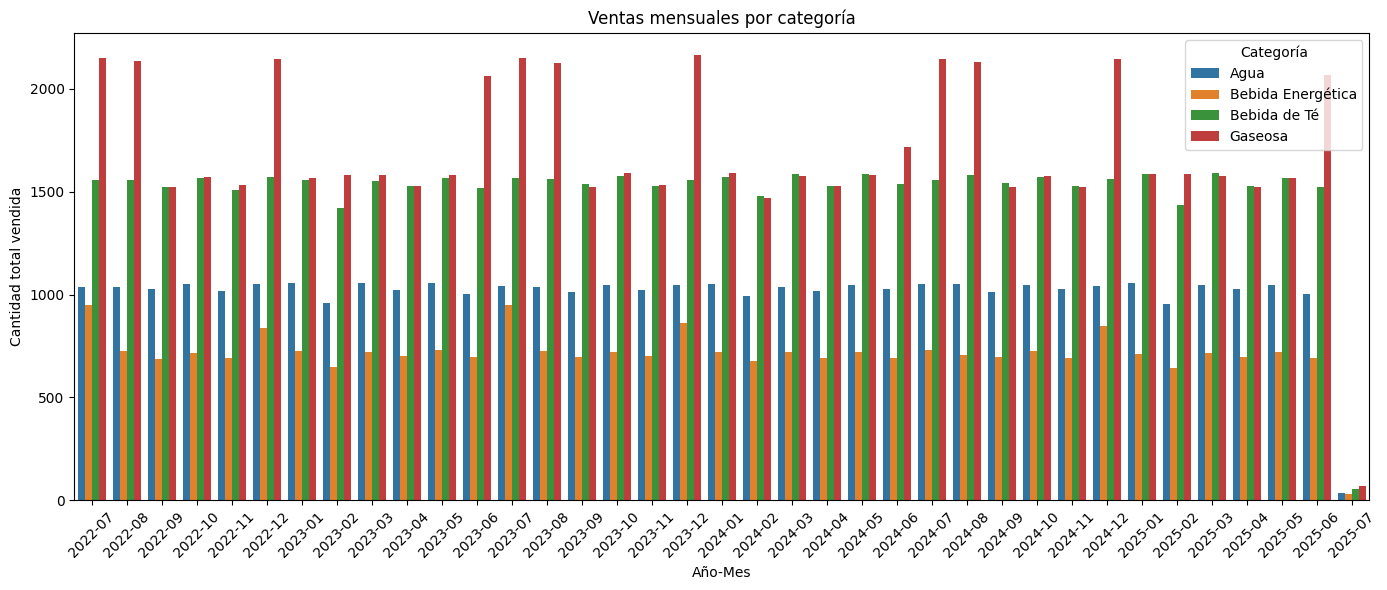

In [123]:
# Unir ventas con productos para obtener la categoría y extraer año-mes
ventas_cat = df_ventas1.join(df_productos.select(['producto_id', 'categoria']), on='producto_id', how='left')
ventas_cat = ventas_cat.with_columns([
    pl.col('fecha').str.strptime(pl.Date, '%Y-%m-%d').dt.strftime('%Y-%m').alias('anio_mes')
])

# Agrupar por año-mes y categoría usando Polars
ventas_mes_cat = ventas_cat.group_by(['anio_mes', 'categoria']).agg([
    pl.sum('cantidad').alias('total_cantidad')
]).sort(['anio_mes', 'categoria'])

# Convertir a pandas para graficar
ventas_mes_cat_pd = ventas_mes_cat.to_pandas()

plt.figure(figsize=(14, 6))
sns.barplot(data=ventas_mes_cat_pd, x='anio_mes', y='total_cantidad', hue='categoria', ci=None)
plt.title('Ventas mensuales por categoría')
plt.xlabel('Año-Mes')
plt.ylabel('Cantidad total vendida')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()


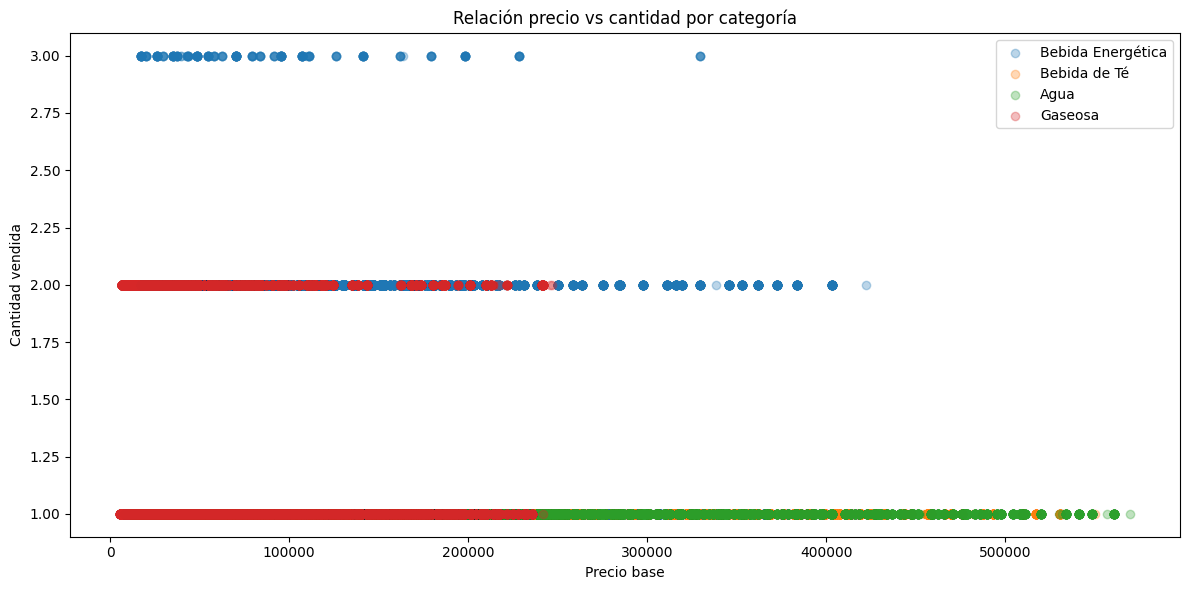

In [124]:

plt.figure(figsize=(12,6))
ventas_precio = df_ventas1.join(df_historico_precios.select(['historico_precio_id', 'precio_base', 'producto_id']), on='historico_precio_id', how='left')
ventas_precio_cat = ventas_precio.join(df_productos.select(['producto_id', 'categoria']), on='producto_id', how='left')
for cat in ventas_precio_cat['categoria'].unique().to_list():
    cat_df = ventas_precio_cat.filter(pl.col('categoria') == cat)
    if not cat_df.is_empty():
        plt.scatter(cat_df['precio_base'], cat_df['cantidad'], alpha=0.3, label=cat)
plt.title('Relación precio vs cantidad por categoría')
plt.xlabel('Precio base')
plt.ylabel('Cantidad vendida')
plt.legend()
plt.tight_layout()
plt.show()


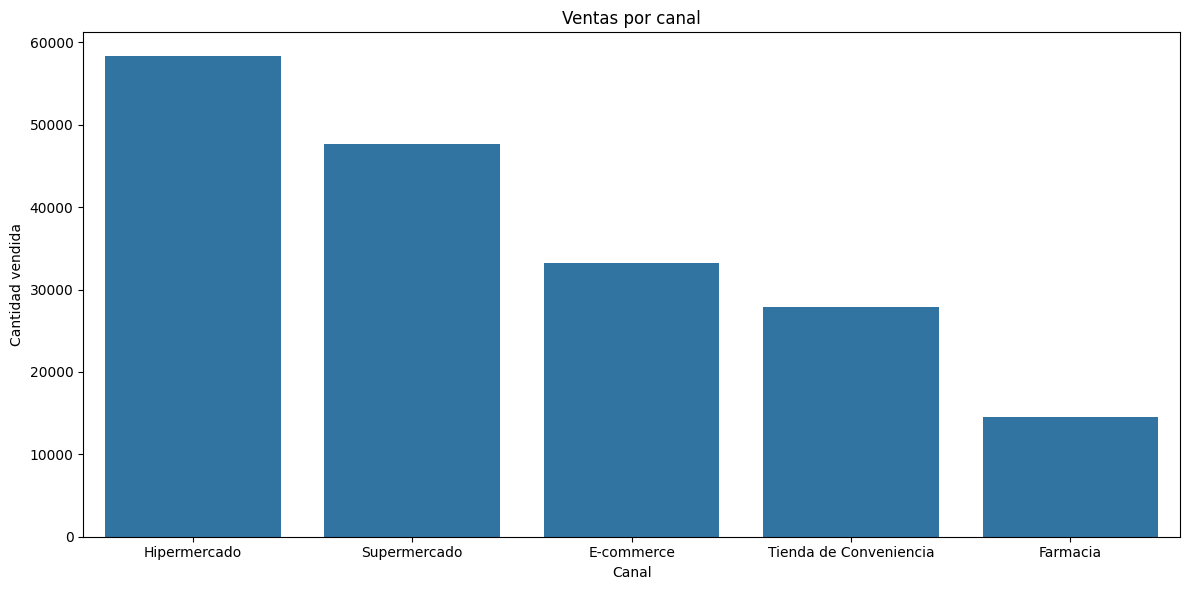

In [125]:

plt.figure(figsize=(12,6))
ventas_por_canal = df_ventas1.join(df_canales.select(['canal_id', 'nombre_canal']), on='canal_id', how='left').group_by('nombre_canal').agg(pl.sum('cantidad').alias('total_cantidad')).sort('total_cantidad', descending=True)
sns.barplot(x=ventas_por_canal['nombre_canal'], y=ventas_por_canal['total_cantidad'])
plt.title('Ventas por canal')
plt.xlabel('Canal')
plt.ylabel('Cantidad vendida')
plt.tight_layout()
plt.show()

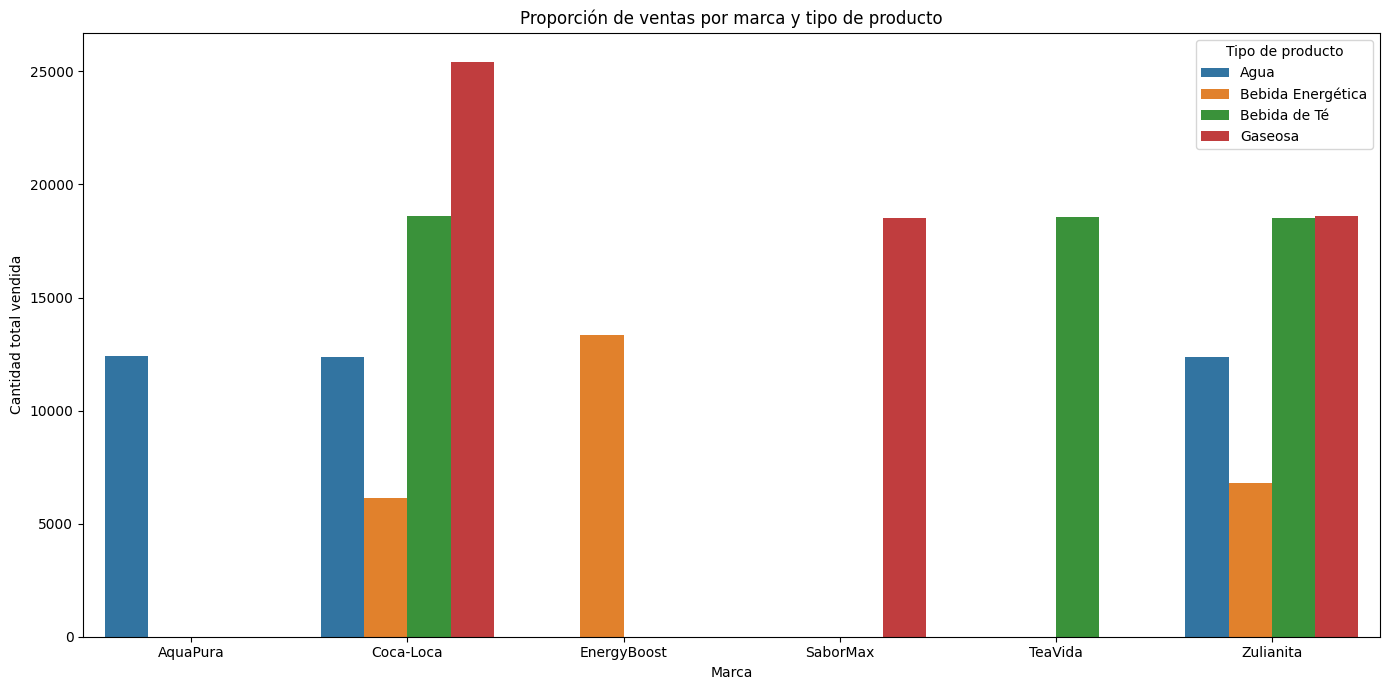

In [126]:
# Verificar proporción de ventas por marca y tipo de producto
import matplotlib.pyplot as plt
import seaborn as sns

# Unir ventas con productos para obtener marca y categoría
ventas_marca_tipo = df_ventas1.join(df_productos.select(['producto_id', 'marca', 'categoria']), on='producto_id', how='left')

# Agrupar por marca y categoría
ventas_marca_cat = ventas_marca_tipo.group_by(['marca', 'categoria']).agg([
    pl.sum('cantidad').alias('total_cantidad')
]).sort(['marca', 'categoria'])

# Convertir a pandas para graficar
ventas_marca_cat_pd = ventas_marca_cat.to_pandas()

plt.figure(figsize=(14, 7))
sns.barplot(data=ventas_marca_cat_pd, x='marca', y='total_cantidad', hue='categoria')
plt.title('Proporción de ventas por marca y tipo de producto')
plt.xlabel('Marca')
plt.ylabel('Cantidad total vendida')
plt.legend(title='Tipo de producto')
plt.tight_layout()
plt.show()

In [127]:

# --- Guardar en CSV ---
df_clientes.write_csv('clientes.csv')
df_productos.write_csv('productos.csv')
df_historico_precios.write_csv('historico_precios.csv')
df_canales.write_csv('canales.csv')
df_regiones.write_csv('regiones.csv')
df_promociones.write_csv('promociones.csv')
df_inventarios.write_csv('inventarios.csv')
df_ventas1.write_csv('ventas.csv')

print(f"\nConjuntos de datos generados y guardados como CSV.")
print(f"Total de ventas: {len(df_ventas1)}")
print(f"Total de productos: {len(df_productos)}")
print(f"Total de entradas de historial de precios: {len(df_historico_precios)}")
print(f"Total de clientes: {len(df_clientes)}")
print(f"Total de regiones: {len(df_regiones)}")
print(f"Total de canales: {len(df_canales)}")
print(f"Total de promociones: {len(df_promociones)}")
print(f"Total de entradas de inventario: {len(df_inventarios)}")

# --- Verificación de distribución de regiones en clientes ---
print("\nDistribución de regiones en clientes:")
region_dist = df_clientes.group_by('ciudad').agg(pl.count('cliente_id').alias('num_clientes')).sort('num_clientes', descending=True)
for row in region_dist.iter_rows(named=True):
    print(f"{row['ciudad']}: {row['num_clientes']} clientes ({row['num_clientes']/n_clientes*100:.2f}%)")

# --- Verificación de ventas por categoría ---
print("\nVentas por categoría (porcentaje del total de unidades):")
ventas_por_categoria = df_ventas1.join(df_productos.select(['producto_id', 'categoria']), on='producto_id', how='left').group_by('categoria').agg(pl.sum('cantidad').alias('total_cantidad')).sort('total_cantidad', descending=True)
total_cantidad = ventas_por_categoria['total_cantidad'].sum()
for row in ventas_por_categoria.iter_rows(named=True):
    porcentaje = (row['total_cantidad'] / total_cantidad) * 100
    print(f"{row['categoria']}: {row['total_cantidad']} unidades ({porcentaje:.2f}%)")



Conjuntos de datos generados y guardados como CSV.
Total de ventas: 167755
Total de productos: 162
Total de entradas de historial de precios: 7290
Total de clientes: 1500
Total de regiones: 5
Total de canales: 5
Total de promociones: 50
Total de entradas de inventario: 3240

Distribución de regiones en clientes:
Medellín: 424 clientes (28.27%)
Bogotá: 374 clientes (24.93%)
Barranquilla: 267 clientes (17.80%)
Cali: 259 clientes (17.27%)
Cartagena: 176 clientes (11.73%)

Ventas por categoría (porcentaje del total de unidades):
Gaseosa: 62538 unidades (34.43%)
Bebida de Té: 55663 unidades (30.65%)
Agua: 37139 unidades (20.45%)
Bebida Energética: 26298 unidades (14.48%)
